# Ship Route Optimization
### Ahmed Ansari, Sarthak Choudhary, Manoj Arulmurugan

## Table of contents
1. [Introduction](#introduction)
2. [Mathematical Model](#mathematical_model)

## Introduction

1. What?

Freight ships are an important part of global trade today with total merchant ship estimated to be around 100,000 in number today [https://www.atlas-mag.net/en/category/tags/focus/the-world-merchant-fleet]. It is important in terms of time, cost and profitability to optimize the route that a merchant ship must take from its port of origin to all the ports that it must call upon.

In real life, there is a variety of objectives and constraints that define this interesting optimization problem. For example, a freight company may prioritize minimizing the fuel cost while ensuring that a ship visits all ports (in a set). There could be certain constraints such as the maximum distance the ship is allowed to travel between ports before it must refuel, or certain regions that it must avoid because of inclement weather, hostile waters, high levies, or congestion. It is also common for ships to exploit natural currents or for sail-driven ships to utilize wind directions to save on fuel and/or save time between its calls.

In many scenarios, objectives may even change mid-journey. For example, a crawler that starts from its port of origin, port A, visits a set of ports B, C and D and still has to   Frequently, there are certain zones that a ship might want to avoid, including hostile waters, shallow waters, inclement weather conditions, or regions with high ship density???

This problem is a variant of the **travelling salesman problem (TSP)**, although in this case, the underlying application, challenges and variety of possibilities is different from the classical problem. Discuss and describe differences.

What's being used in the industry and algorithms. Citations???

3. What is the scope of work

In this project, we limit ourselves to x??? interesting cases. We start of from a basic model to validate our ideas and iron out limitations with the constraints and issues with visualization. Some of these constraints (and their remedies) are described under their respective model.

We define the problem on an $n\times n$ grid of points. These points are traversable by a ship and are defined by a node index *and* a tuple of coordinates (x, y). These points can take the form of any of the following:
1. port of origin (POO)
2. port to call on
3. no-go zone
4. boost-zone

The number of ports to call-on, np-go zones and boost-zones are user-defined, and a function randomly assigns a node to these. Therefore, all data is user-input or randomized. This representation has the potential to be extended to an actual geographical maritime map as well, and allows ready visualization.

## Mathematical model

### Problem 1 - Base Problem and Issues
We impose a few constraints on our basic problem:
1. There is only one ship and only on port of origin
2. The ship must call on *all* the ports defined
3. The ship cannot revisit a port and it cannot return to the port of origin
4. No-go zones cannot be visited
5. The ship is only allowed to travel to the nearest 8 points around it on the grid, i.e. only to the points in a square around it.

#### Mathematical representation
**Sets**

**Decision variables**
$$x_{ij} \quad \text {from node i to j} \quad | \quad  x \in \{0, 1\} \, \forall i, j$$

\begin{equation}
x_{ij} =
    \begin{cases}
        0, & \text{if path } ij  \text{ is not on the ship route}\\
        1, & \text{if path } ij \text{ is on the ship route}
    \end{cases}
\end{equation}

**Constraints**

1. There is a single outflow from the port of origin.
$$\sum_{j \in nodes} x_{pj} = 1$$
2. There is no inflow to the port of origin.
$$\sum_{i \in nodes} x_{ip} = 0$$

## Solution

In [1]:
### Add packages here
# using Pkg
# # Pkg.add("StatsBase")
# Pkg.add("Juniper")

In [2]:
using PyPlot, MeshGrid, StatsBase, LinearAlgebra

In [3]:
using JuMP, GLPK, COSMO, Gurobi, Juniper, Ipopt

### Helper Functions

In [4]:
function nodeToNum(node, n)
   return node[1]*n+node[2];
end

nodeToNum (generic function with 1 method)

In [5]:
function nodeToCoord(node, spacing)
   return spacing*node
end

nodeToCoord (generic function with 1 method)

In [6]:
function numToCoord(num, n, spacing)
    node_y = div.(num, n);
    node_x = num.%n;
    node = hcat(node_x, node_y);
    return spacing*node;
end

numToCoord (generic function with 1 method)

In [7]:
function numToNode(num, n)
    node_y = div.(num, n);
    node_x = num.%n;
    node = hcat(node_x, node_y);
    return node;
end

numToNode (generic function with 1 method)

In [8]:
function initializeParam(n, spacing, m, k, b, fill_ratio = 0.25)
    grid_size = n*n;
       
    # Check that values are whole numbers
    if m <= 1
        error("Increase m!")
    end
    
    # Check that values are whole numbers
    if !isinteger(n) || !isinteger(m) || !isinteger(k) || !isinteger(0)
        error("Only integer values are allowed for n, m and k!")
    end
        
    # Check that number of ports and no-go zones does not exceed a certain percentage of grid size
    if (b + k + m) >= fill_ratio*grid_size
        error("Number of ports and no-go zones cannot exceed $(fill_ratio*100)% of grid size. Reinitialize numnber of ports!")
    end
    
    grid_data = [n, spacing, m, k, b];
end

initializeParam (generic function with 2 methods)

In [9]:
function randomizePorts(grid_data)
### randomize location of all ports and no-go zones
   
    n = Int(grid_data[1]);
    spacing = grid_data[2];
    m = Int(grid_data[3]);
    k = Int(grid_data[4]);

    # assign nodes to ports and no-go zones
    node = rand(0:n-1, m+k, 2);
    coord = spacing*node;

    port_coord = coord[1:m, :]
    no_go_coord = coord[m+1:end, :];

    # assign random port as port of origin
    rand_idx = rand(1:m);
    port_of_origin_coord = port_coord[rand_idx, :]

    return port_coord, no_go_coord, port_of_origin_coord
    
end

randomizePorts (generic function with 1 method)

In [10]:
function randomizePortsNoRepeat(grid_data)
### randomize location of all ports and no-go zones
   
    n = Int(grid_data[1]);
    spacing = grid_data[2];
    m = Int(grid_data[3]);
    k = Int(grid_data[4]);

    total_nodes = n^2;
    pool = 0:(total_nodes-1);

    # assign nodes to ports and no-go zones
    nums = sample(pool, m+k, replace=false);
    port_num = nums[1:m, :];
    no_go_num = nums[m+1:end, :];
    
    # node = hcat(node_x, node_y)
    # coord = spacing*node;

    # port_node = numToNode(port_num, n);
    # port_coord = spacing*port_node;
    # no_go_node = numToNode(no_go_num, n);
    # no_go_coord = spacing*no_go_node;

    # assign random port as port of origin
    rand_idx = rand(1:m);
    port_of_origin_num = port_num[rand_idx];
    # port_of_origin_node = numToNode(port_of_origin_num, n);
    # port_of_origin_coord = spacing*port_of_origin_node;

    return port_num, port_of_origin_num, no_go_num
    
end

randomizePortsNoRepeat (generic function with 1 method)

In [11]:
function randomizePortsBoostZones(grid_data)
### randomize location of all ports and no-go zones and boost zones
   
    n = Int(grid_data[1]);
    spacing = grid_data[2];
    m = Int(grid_data[3]);
    k = Int(grid_data[4]); # no-go 
    b = Int(grid_data[5]); # boost zones

    total_nodes = n^2;
    pool = 0:(total_nodes-1);

    # assign nodes to ports and no-go zones
    nums = sample(pool, m + k + b, replace=false);
    port_num = nums[1:m, :];
    no_go_num = nums[m+1:m+k, :];
    boost_num = nums[m+k+1:end, :];
    
    # node = hcat(node_x, node_y)
    # coord = spacing*node;

    # port_node = numToNode(port_num, n);
    # port_coord = spacing*port_node;
    # no_go_node = numToNode(no_go_num, n);
    # no_go_coord = spacing*no_go_node;

    # assign random port as port of origin
    rand_idx = rand(1:m);
    port_of_origin_num = port_num[rand_idx];
    # port_of_origin_node = numToNode(port_of_origin_num, n);
    # port_of_origin_coord = spacing*port_of_origin_node;

    return port_num, port_of_origin_num, no_go_num, boost_num
    
end

randomizePortsBoostZones (generic function with 1 method)

In [12]:
function randomizePortProfit(grid_data, min_val, max_val)
# Randomize profit for each port    
    m = Int(grid_data[3]);

    return min_val .+ (max_val - min_val) .* rand(m);
end

randomizePortProfit (generic function with 1 method)

In [13]:
function visualizeGrid(grid_data, port_num, port_of_origin_num, no_go_num, soln)
    n = Int(grid_data[1]);
    spacing = grid_data[2];
    origin = [0, 0];

    port_coord = numToCoord(port_num, n, spacing);
    port_of_origin_coord = numToCoord(port_of_origin_num, n, spacing);
    no_go_coord = numToCoord(no_go_num, n, spacing);

    grid_size = n^2;

    grid_points_x = [origin[1] + i*spacing for i in range(0, n-1)];
    grid_points_y = [origin[2] + j*spacing for j in range(0, n-1)];

    grid_points_x, grid_points_y = meshgrid(grid_points_x, grid_points_y);
    # size(grid_points_mesh);

    grid_points = hcat(grid_points_x, grid_points_y);
    # grid_points = [grid_points_x, grid_points_y];
    size(grid_points);

    # plot
    grid_color_RGB = [248, 131, 121]./255;
    alpha_plot = 0.5;
    fig_size = max((10,10),(n, n));
    f = figure(figsize=(5, 5));
    scatter(grid_points_x, grid_points_y, alpha = alpha_plot, color = grid_color_RGB, s = 20);
    ax = gca();
    ax.axis("equal");
    ax.axis("off"); # hide axes spines/values

    # plot port data
    port_color_RGB = [25, 100, 50]./255;
    alpha_port = 1;
    scatter(port_coord[:, 1], port_coord[:, 2], alpha = alpha_port, color = port_color_RGB, marker = "o", s = 100);

    # plot no_go data
    no_go_color_RGB = [0, 0, 0]./255;
    alpha_no_go = 1;
    scatter(no_go_coord[:, 1], no_go_coord[:, 2], alpha = alpha_no_go, color = no_go_color_RGB, marker = "x", s = 150);

    # plot port of origin
    origin_port_color_RGB = [255, 87, 51]./255;
    alpha_origin_port = 1;
    scatter(port_of_origin_coord[1], port_of_origin_coord[2], alpha = alpha_origin_port, color = origin_port_color_RGB, marker = "*", s = 200);

    if soln != 0
        # plot edges
        for i=0:grid_size-1
            for j=0:grid_size-1
                if soln[i+1, j+1] == 1
                    # println(soln[i+1, j+1])
                    line_start = numToCoord(i, n, spacing);
                    line_end = numToCoord(j, n, spacing);

                    # println(line_start);
                    # println(line_end);
    
                    # plot([line_start[1], line_end[1]], [line_start[2], line_end[2]], "r-")
                    arrow(line_start[1], line_start[2],  line_end[1]-line_start[1], line_end[2]- line_start[2], head_width=0.2, head_length=0.2, fc="lightyellow", ec="orange")
                end
            end
        end
    end

    # plot([0, 1], [1, 2], "r-")
    return f 
end

visualizeGrid (generic function with 1 method)

In [14]:
function visualizeGridBoost(grid_data, port_num, port_of_origin_num, no_go_num, boost_num, soln)
    n = Int(grid_data[1]);
    spacing = grid_data[2];
    origin = [0, 0];

    port_coord = numToCoord(port_num, n, spacing);
    port_of_origin_coord = numToCoord(port_of_origin_num, n, spacing);
    no_go_coord = numToCoord(no_go_num, n, spacing);
    boost_coord = numToCoord(boost_num, n, spacing);

    grid_size = n^2;

    grid_points_x = [origin[1] + i*spacing for i in range(0, n-1)];
    grid_points_y = [origin[2] + j*spacing for j in range(0, n-1)];

    grid_points_x, grid_points_y = meshgrid(grid_points_x, grid_points_y);
    # size(grid_points_mesh);

    grid_points = hcat(grid_points_x, grid_points_y);
    # grid_points = [grid_points_x, grid_points_y];
    size(grid_points);

    # plot
    grid_color_RGB = [248, 131, 121]./255;
    alpha_plot = 0.5;
    fig_size = max((10,10),(n, n));
    f = figure(figsize=(5, 5));
    scatter(grid_points_x, grid_points_y, alpha = alpha_plot, color = grid_color_RGB, s = 20);
    ax = gca();
    ax.axis("equal");
    ax.axis("off"); # hide axes spines/values

    # plot port data
    port_color_RGB = [25, 100, 50]./255;
    alpha_port = 1;
    scatter(port_coord[:, 1], port_coord[:, 2], alpha = alpha_port, color = port_color_RGB, marker = "o", s = 100);

    # plot no_go data
    no_go_color_RGB = [250, 0, 0]./255;
    alpha_no_go = 1;
    scatter(no_go_coord[:, 1], no_go_coord[:, 2], alpha = alpha_no_go, color = no_go_color_RGB, marker = "v", s = 50);

    # plot boost data
    if b != 0
        boost_color_RGB = [0, 0, 255]./255;
        alpha_boost = 1;
        scatter(boost_coord[:, 1], boost_coord[:, 2], alpha = alpha_boost, color = boost_color_RGB, marker = "^", s = 50);
    end
    
    # plot port of origin
    origin_port_color_RGB = [255, 87, 51]./255;
    alpha_origin_port = 1;
    scatter(port_of_origin_coord[1], port_of_origin_coord[2], alpha = alpha_origin_port, color = origin_port_color_RGB, marker = "*", s = 200);

    if soln != 0
        # plot edges
        for i=0:grid_size-1
            for j=0:grid_size-1
                if soln[i+1, j+1] == 1
                    # println(soln[i+1, j+1])
                    line_start = numToCoord(i, n, spacing);
                    line_end = numToCoord(j, n, spacing);

                    # println(line_start);
                    # println(line_end);
    
                    # plot([line_start[1], line_end[1]], [line_start[2], line_end[2]], "r-")
                    arrow(line_start[1], line_start[2],  line_end[1]-line_start[1], line_end[2]- line_start[2], head_width=0.2, head_length=0.2, fc="lightyellow", ec="orange")
                end
            end
        end
    end

    # plot([0, 1], [1, 2], "r-")
    return f 
end

visualizeGridBoost (generic function with 1 method)

### Minimize total distance travelled

In [15]:
function optModelMinCost(grid_data, port_num, port_of_origin_num, no_go_num, solver)
    grid_size = n*n;

    # nodes other than ports and no-go zones
    all_num = [i for i=0:grid_size-1];
    all_else_num = setdiff(all_num, union(port_num, no_go_num))
    # println(all_else_num)
    
    model = Model();
    # all edges from a node to all other nodes
    # @show 
    @variable(model, x[i = 0:grid_size-1, j = 0:grid_size-1], Bin);
    # @show 
    @variable(model, z[i = 1:m], Bin);
    
    # MTZ to prevent loops
    # defined for all nodes
    # u is a continuous variable initialized at the port of origin to be 0
    @variable(model, u[i = 0:grid_size-1] >= 0);
    @constraint(model, u[1] == 0) # for POO;
    
    # edge cost: euclidean norm
    c = zeros(grid_size, grid_size);
    
    tol = 10^-5;

    # Total cost
    cost = 0; 
    
    # idx=0;
    
    # cost and same node flow
    for i = 0:grid_size-1
        # println(i);
    
        for j = 0:grid_size-1
            if i == j
                # no flow
                # @show 
                @constraint(model, x[i, j] == 0);
            end

            # MTZ constraint
            @constraint(model, u[i]- u[j] + grid_size*x[i, j] <= grid_size - 1);
    
            # edge cost
            c[i+1, j+1] = norm(numToCoord(i, n, spacing)- numToCoord(j, n, spacing));
            cost += c[i+1, j+1]*x[i, j];
              
            # all edges other than the eight closest ones are zero 
            if c[i+1, j+1] > (sqrt(2) + tol)
                @constraint(model, x[i, j] == 0);
            end    
        end   
    end
    
    # port of origin
    sum_in_POO = 0;
    sum_out_POO = 0;
    
    for j = 0:grid_size-1
        sum_out_POO += x[port_of_origin_num, j];
        sum_in_POO += x[j, port_of_origin_num]; 
    end
    
    # @show 
    @constraint(model, sum_out_POO==1);
    # @show 
    @constraint(model, sum_out_POO - sum_in_POO == 1); # or sum in == 0
    
    ## for other ports
    # for if-then constraints
    e = 1;
    l = -1;
    u = 2;
    sum_terminal = 0;
    
    for p=1:length(port_num)
        i = port_num[p];
        if i!=port_of_origin_num
            # println(i);
            sum_in_port = 0;
            sum_out_port = 0;
    
            for j = 0:grid_size-1
                # port of origin
                sum_out_port += x[i, j];
                sum_in_port += x[j, i];
    
                # if flow from edge is 1, then no flow in the opposite direction
                # @show 
                @constraint(model, x[i, j] + x[j, i] <= 1);
               
            end

            ## if-then constraints
            # @show 
            # @constraint(model, sum_out_port >= l*z[p] +e*(1-z[p]));
            # @show 
            # @constraint(model, sum_out_port <= u*(1-z[p]));
            # @show 
            @constraint(model, sum_in_port == 1);
            # @constraint(model, sum_in_port >= 1);
            # @show 
            @constraint(model, sum_out_port - sum_in_port <= 0);
    
            # sum_terminal += z[p];
        end
    end
    # @show 
    # @constraint(model, sum_terminal == 1);
    
    
    # for no-go zones
    for g=1:length(no_go_num)
        i = no_go_num[g];
        
        # println(i);
        
        sum_in_no_go = 0;
        sum_out_no_go = 0;
    
        for j = 0:grid_size-1
            # port of origin
            sum_out_no_go += x[i, j];
            sum_in_no_go += x[j, i];
        
           
        end
        # @show 
        @constraint(model, sum_out_no_go == 0);
        # @show 
        @constraint(model, sum_in_no_go == 0);
        
    end
    
    # for all-else
    for a=1:length(all_else_num)
        i = all_else_num[a];
        
        # println(i);
        
        sum_out_all_else = 0;
        sum_in_all_else = 0;
    
        for j = 0:grid_size-1
            # port of origin
            sum_out_all_else += x[i, j];
            sum_in_all_else += x[j, i];
    
            # if flow from edge is 1, then no flow in the opposite direction
            # @show 
            # @constraint(model, x[i, j] + x[j, i] <= 1);
           
        end
        # @show 
        @constraint(model, sum_out_all_else - sum_in_all_else == 0);
        
    end
    
    #objective function
    @objective(model, Min, cost);

    set_optimizer(model, solver.Optimizer);
    set_silent(model);
    optimize!(model);

    println(termination_status(model));

    try
        x_opt = JuMP.value.(x);
        z_opt = JuMP.value.(z);
        obj_opt = objective_value(model);
        
        return x_opt, z_opt, obj_opt, model
    catch
    # else
        error("Model did not optimize!")
    end

end

optModelMinCost (generic function with 1 method)

### Allow ship to pass through no-go zones but assign penalty

In [16]:
function optModelAllowNoGo(grid_data, port_num, port_of_origin_num, no_go_num, penalty_factor, solver)
    grid_size = n*n;

    # nodes other than ports and no-go zones
    all_num = [i for i=0:grid_size-1];
    all_else_num = setdiff(all_num, union(port_num, no_go_num))
    # println(all_else_num)
    
    model = Model();
    # all edges from a node to all other nodes
    # @show 
    @variable(model, x[i = 0:grid_size-1, j = 0:grid_size-1], Bin);
    # @show 
    @variable(model, z[i = 1:m], Bin);
    
    # MTZ to prevent loops
    # defined for all nodes
    # u is a continuous variable initialized at the port of origin to be 0
    @variable(model, u[i = 0:grid_size-1] >= 0);
    @constraint(model, u[1] == 0) # for POO;
    
    # edge cost: euclidean norm
    norm_dist = zeros(grid_size, grid_size);
    c = zeros(grid_size, grid_size);
    
    tol = 10^-5;
    
    cost = 0; 
    
    # idx=0;
    # cost and same node flow
    for i = 0:grid_size-1
        # println(i);
    
        for j = 0:grid_size-1
            if i == j
                # no flow
                # @show 
                @constraint(model, x[i, j] == 0);
            end

            # MTZ constraint
            @constraint(model, u[i]- u[j] + grid_size*x[i, j] <= grid_size - 1);
    
            # edge cost
            norm_dist[i+1, j+1] = norm(numToCoord(i, n, spacing) - numToCoord(j, n, spacing));
            c[i+1, j+1] = norm_dist[i+1, j+1];
            
            # If flow coming in or going out of a no-go zone, increase cost by 1.5
            if in(i, no_go_num) || in(j, no_go_num)
                c[i+1, j+1] *= penalty_factor;              
            end

            cost += c[i+1, j+1]*x[i, j];
            
            # all edges other than the eight closest ones are zero 
            if norm_dist[i+1, j+1] > (sqrt(2) + tol)
                @constraint(model, x[i, j] == 0);
            end    
        end   
        
    end
    
    # port of origin
    sum_in_POO = 0;
    sum_out_POO = 0;
    
    for j = 0:grid_size-1
        sum_out_POO += x[port_of_origin_num, j];
        sum_in_POO += x[j, port_of_origin_num]; 
    end
    
    # @show 
    @constraint(model, sum_out_POO == 1);
    # @show 
    @constraint(model, sum_out_POO - sum_in_POO == 1);
    
    ## for other ports
    # for if-then constraints
    e = 1; # epsilon
    l = -1; # lower bound
    u = 2; # upper bound
    sum_terminal = 0;
    
    for p=1:length(port_num)
        i = port_num[p];
        if i!=port_of_origin_num
            # println(i);
            sum_in_port = 0;
            sum_out_port = 0;
    
            for j = 0:grid_size-1
                # port of origin
                sum_out_port += x[i, j];
                sum_in_port += x[j, i];
    
                # if flow from edge is 1, then no flow in the opposite direction
                # @show 
                @constraint(model, x[i, j] + x[j, i] <= 1);
               
            end

            ## if-then constraints
            # @show 
            # @constraint(model, sum_out_port >= l*z[p] +e*(1-z[p]));
            # # @show 
            # @constraint(model, sum_out_port <= u*(1-z[p]));
            # @show 
            @constraint(model, sum_in_port == 1);
            # @constraint(model, sum_in_port >= 1);
            # @show 
            @constraint(model, sum_out_port - sum_in_port <= 0);
    
            # sum_terminal += z[p];
        end
    end
    # @show 
    # @constraint(model, sum_terminal == 1);
    
    
    # for no-go zones
    for g=1:length(no_go_num)
        i = no_go_num[g];
        
        # println(i);
        
        sum_in_no_go = 0;
        sum_out_no_go = 0;
    
        for j = 0:grid_size-1
            # port of origin
            sum_out_no_go += x[i, j];
            sum_in_no_go += x[j, i];
        
        end

        # conserve flow
        @constraint(model, sum_out_no_go - sum_in_no_go ==0);
        
    end
    
    # for all-else
    for a=1:length(all_else_num)
        i = all_else_num[a];
        
        # println(i);
        
        sum_out_all_else = 0;
        sum_in_all_else = 0;
    
        for j = 0:grid_size-1
            # port of origin
            sum_out_all_else += x[i, j];
            sum_in_all_else += x[j, i];
    
            # if flow from edge is 1, then no flow in the opposite direction
            # @show 
            # @constraint(model, x[i, j] + x[j, i] <= 1);
           
        end
        # @show 
        @constraint(model, sum_out_all_else - sum_in_all_else == 0);
        
    end
    
    #objective function
    @objective(model, Min, cost);

    @show model

    set_optimizer(model, solver.Optimizer);
    # set_silent(model);
    optimize!(model);

    println(termination_status(model));

    try
        x_opt = JuMP.value.(x);
        z_opt = JuMP.value.(z);
        obj_opt = objective_value(model);
            
        return x_opt, z_opt, obj_opt, model
    catch
    # else
        error("Model did not optimize!")
    end

end

optModelAllowNoGo (generic function with 1 method)

### With Boost Zones

In [17]:
function optModelNoGoBoost(grid_data, port_num, port_of_origin_num, no_go_num, boost_num, penalty_factor, boost_factor, solver)
    grid_size = n*n;

    # nodes other than ports and no-go zones
    all_num = [i for i=0:grid_size-1];
    all_else_num = setdiff(all_num, union(port_num, no_go_num, boost_num))
    # println(all_else_num)
    
    model = Model();
    # all edges from a node to all other nodes
    # @show 
    @variable(model, x[i = 0:grid_size-1, j = 0:grid_size-1], Bin);
    # @show 
    @variable(model, z[i = 1:m], Bin);
    
    # MTZ to prevent loops
    # defined for all nodes
    # u is a continuous variable initialized at the port of origin to be 0
    @variable(model, u[i = 0:grid_size-1] >= 0);
    @constraint(model, u[1] == 0) # for POO;
    
    # edge cost: euclidean norm
    norm_dist = zeros(grid_size, grid_size);
    c = zeros(grid_size, grid_size);
    
    tol = 10^-5;
    
    cost = 0; 
    
    # idx=0;
    # cost and same node flow
    for i = 0:grid_size-1
        # println(i);
    
        for j = 0:grid_size-1
            if i == j
                # no flow
                # @show 
                @constraint(model, x[i, j] == 0);
            end

            # MTZ constraint
            @constraint(model, u[i]- u[j] + grid_size*x[i, j] <= grid_size - 1);
    
            # edge cost
            norm_dist[i+1, j+1] = norm(numToCoord(i, n, spacing) - numToCoord(j, n, spacing));
            c[i+1, j+1] = norm_dist[i+1, j+1];
            
            # If flow coming going out of a no-go zone, increase cost by penalty factor
            # if in(i, no_go_num) || in(j, no_go_num)
            if in(j, no_go_num)
                c[i+1, j+1] *= penalty_factor;              
            end

             # If flow coming into a boost zone, decrease cost by boost factor
            if in(j, boost_num)
                c[i+1, j+1] /= boost_factor;              
            end

            cost += c[i+1, j+1]*x[i, j];
            
            # all edges other than the eight closest ones are zero 
            if norm_dist[i+1, j+1] > (sqrt(2) + tol)
                @constraint(model, x[i, j] == 0);
            end    
        end   
        
    end
    
    # port of origin
    sum_in_POO = 0;
    sum_out_POO = 0;
    
    for j = 0:grid_size-1
        sum_out_POO += x[port_of_origin_num, j];
        sum_in_POO += x[j, port_of_origin_num]; 
    end
    
    # @show 
    @constraint(model, sum_out_POO == 1);
    # @show 
    @constraint(model, sum_out_POO - sum_in_POO == 1);
    
    ## for other ports
    # for if-then constraints
    e = 1; # epsilon
    l = -1; # lower bound
    u = 2; # upper bound
    sum_terminal = 0;
    
    for p=1:length(port_num)
        i = port_num[p];
        if i!=port_of_origin_num
            # println(i);
            sum_in_port = 0;
            sum_out_port = 0;
    
            for j = 0:grid_size-1
                # port of origin
                sum_out_port += x[i, j];
                sum_in_port += x[j, i];
    
                # if flow from edge is 1, then no flow in the opposite direction
                # @show 
                @constraint(model, x[i, j] + x[j, i] <= 1);
               
            end

            ## if-then constraints
            # @show 
            # @constraint(model, sum_out_port >= l*z[p] +e*(1-z[p]));
            # # @show 
            # @constraint(model, sum_out_port <= u*(1-z[p]));
            # @show 
            @constraint(model, sum_in_port == 1);
            # @constraint(model, sum_in_port >= 1);
            # @show 
            @constraint(model, sum_out_port - sum_in_port <= 0);
    
            # sum_terminal += z[p];
        end
    end
    # @show 
    # @constraint(model, sum_terminal == 1);
    
     # for boost zones
    for b=1:length(boost_num)
        i = boost_num[b];
        
        # println(i);
        
        sum_in_boost = 0;
        sum_out_boost = 0;
    
        for j = 0:grid_size-1
            # port of origin
            sum_out_boost += x[i, j];
            sum_in_boost += x[j, i];
        
        end

        # conserve flow
        @constraint(model, sum_out_boost - sum_in_boost ==0);
        
    end
    
    # for no-go zones
    for g=1:length(no_go_num)
        i = no_go_num[g];
        
        # println(i);
        
        sum_in_no_go = 0;
        sum_out_no_go = 0;
    
        for j = 0:grid_size-1
            # port of origin
            sum_out_no_go += x[i, j];
            sum_in_no_go += x[j, i];
        
        end

        # conserve flow
        @constraint(model, sum_out_no_go - sum_in_no_go ==0);
        
    end
    
    # for all-else
    for a=1:length(all_else_num)
        i = all_else_num[a];
        
        # println(i);
        
        sum_out_all_else = 0;
        sum_in_all_else = 0;
    
        for j = 0:grid_size-1
            # port of origin
            sum_out_all_else += x[i, j];
            sum_in_all_else += x[j, i];
    
            # if flow from edge is 1, then no flow in the opposite direction
            # @show 
            # @constraint(model, x[i, j] + x[j, i] <= 1);
           
        end
        # @show 
        @constraint(model, sum_out_all_else - sum_in_all_else == 0);
        
    end
    
    #objective function
    @objective(model, Min, cost);

    @show model

    set_optimizer(model, solver.Optimizer);
    # set_silent(model);
    optimize!(model);

    println(termination_status(model));

    try
        x_opt = JuMP.value.(x);
        z_opt = JuMP.value.(z);
        obj_opt = objective_value(model);
            
        return x_opt, z_opt, obj_opt, model
    catch
    # else
        error("Model did not optimize!")
    end

end

optModelNoGoBoost (generic function with 1 method)

### Allow any number of ports to be visited >= 1

In [32]:
function optModelMaxProfit(grid_data, port_num, port_of_origin_num, no_go_num, port_profit, solver)
    grid_size = n*n;

    # nodes other than ports and no-go zones
    all_num = [i for i=0:grid_size-1];
    all_else_num = setdiff(all_num, union(port_num, no_go_num))
    # println(all_else_num)
    
    model = Model();
    # all edges from a node to all other nodes
    # @show 
    @variable(model, x[i = 0:grid_size-1, j = 0:grid_size-1], Bin);
    # @show 
    @variable(model, z[i = 1:length(port_num)], Bin);

    # binary variable to ensure >= 1 ports visited (other than POO)
    @variable(model, w[i = 1:length(port_num)], Bin);
    
    # MTZ to prevent loops
    # defined for all nodes
    # u is a continuous variable initialized at the port of origin to be 0
    @variable(model, u[i = 0:grid_size-1] >= 0);
    @constraint(model, u[1] == 0) # for POO;
    
    # edge cost: euclidean norm
    c = zeros(grid_size, grid_size);
    
    tol = 10^-5;

    # Total cost
    cost = 0; 
    
    # idx=0;
    
    # cost and same node flow
    for i = 0:grid_size-1
        # println(i);
    
        for j = 0:grid_size-1
            if i == j
                # no flow
                # @show 
                @constraint(model, x[i, j] == 0);
            end

            # MTZ constraint
            @constraint(model, u[i]- u[j] + grid_size*x[i, j] <= grid_size - 1);
    
            # edge cost
            c[i+1, j+1] = norm(numToCoord(i, n, spacing)- numToCoord(j, n, spacing));
            cost += c[i+1, j+1]*x[i, j];
              
            # all edges other than the eight closest ones are zero 
            if c[i+1, j+1] > (sqrt(2) + tol)
                @constraint(model, x[i, j] == 0);
            end    
        end   
    end
    
    # port of origin
    sum_in_POO = 0;
    sum_out_POO = 0;
    
    for j = 0:grid_size-1
        sum_out_POO += x[port_of_origin_num, j];
        sum_in_POO += x[j, port_of_origin_num]; 
    end
    
    # @show 
    @constraint(model, sum_out_POO==1);
    # @show 
    @constraint(model, sum_out_POO - sum_in_POO == 1); # or sum in == 0
    
    ## for other ports
    # for if-then constraints
    e = 1;
    l = -1;
    u = 2;
    sum_terminal = 0;
    profit = 0;
    
    for p=1:length(port_num)
        i = port_num[p];
        if i!=port_of_origin_num
            # println(i);
            sum_in_port = 0;
            sum_out_port = 0;
    
            for j = 0:grid_size-1
                # port of origin
                sum_out_port += x[i, j];
                sum_in_port += x[j, i];
    
                # if flow from edge is 1, then no flow in the opposite direction
                # @show 
                @constraint(model, x[i, j] + x[j, i] <= 1);
               
            end

            ## if-then constraints
            # @show 
            # @constraint(model, sum_out_port >= l*z[p] +e*(1-z[p]));
            # @show 
            # @constraint(model, sum_out_port <= u*(1-z[p]));
            # @show 
            # @constraint(model, sum_in_port == 1);
            # @constraint(model, sum_in_port >= 1);
            # @show 
            @constraint(model, sum_out_port - sum_in_port <= 0);

            # Added constraint to esnure >= 1 ports visited; this allows skipping some ports
            @constraint(model, sum_in_port - 1 <= u*w[p] - e*(1-w[p])); # if sum_in >=1, w = 1
            @constraint(model, sum_in_port >= l*(1-w[p]) + e*w[p]); # if sum_in <=0, w = 0

            profit += port_profit[p]*w[p];
            # sum_terminal += z[p];
        else
            @constraint(model, w[p] == 0); # for port of origin, redundant?
        end
    end
    # @show 
    # @constraint(model, sum_terminal == 1);
    
    
    # for no-go zones
    for g=1:length(no_go_num)
        i = no_go_num[g];
        
        # println(i);
        
        sum_in_no_go = 0;
        sum_out_no_go = 0;
    
        for j = 0:grid_size-1
            # port of origin
            sum_out_no_go += x[i, j];
            sum_in_no_go += x[j, i];
        
           
        end
        # @show 
        @constraint(model, sum_out_no_go == 0);
        # @show 
        @constraint(model, sum_in_no_go == 0);
        
    end
    
    # for all-else
    for a=1:length(all_else_num)
        i = all_else_num[a];
        
        # println(i);
        
        sum_out_all_else = 0;
        sum_in_all_else = 0;
    
        for j = 0:grid_size-1
            # port of origin
            sum_out_all_else += x[i, j];
            sum_in_all_else += x[j, i];
    
            # if flow from edge is 1, then no flow in the opposite direction
            # @show 
            # @constraint(model, x[i, j] + x[j, i] <= 1);
           
        end
        # @show 
        @constraint(model, sum_out_all_else - sum_in_all_else == 0);
        
    end
    
    #objective function
    # @objective(model, Min, cost);
    @objective(model, Max, profit);

    set_optimizer(model, solver.Optimizer);
    set_silent(model);
    optimize!(model);

    println(termination_status(model));

    try
        x_opt = JuMP.value.(x);
        z_opt = JuMP.value.(z);
        obj_opt = objective_value(model);
        
        return x_opt, z_opt, obj_opt, model
    catch
    # else
        error("Model did not optimize!")
    end

end

optModelMaxProfit (generic function with 1 method)

### Initialize parameters

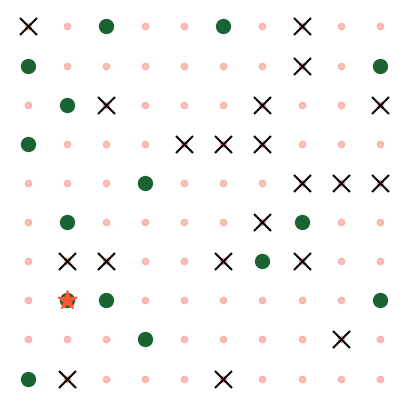

In [33]:
### Grid setup
# grid size (square)
n = 10;
spacing = 1; # always keep 1?

### port information
# number of ports on grid
m = 15;

### no-go zones
k = 20;

# boost zones
b = 0;

grid_data = initializeParam(n, spacing, m, k, b, 0.95);
port_num, port_of_origin_num, no_go_num = randomizePortsNoRepeat(grid_data)
f = visualizeGrid(grid_data, port_num, port_of_origin_num, no_go_num,  0);

### Solve Model

Set parameter Username
Set parameter LicenseID to value 2634157
Academic license - for non-commercial use only - expires 2026-03-09
OPTIMAL
Objective value: 39.45584412271571


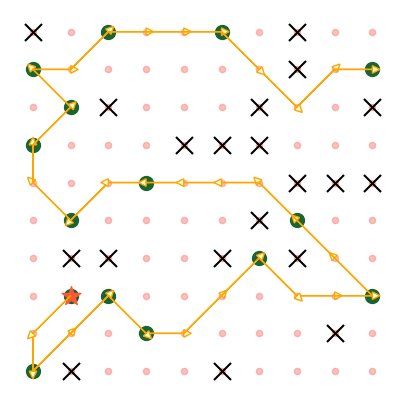

In [35]:
solver = Gurobi;
x_opt, z_opt, obj_opt = optModelMinCost(grid_data, port_num, port_of_origin_num, no_go_num, solver);
println("Objective value: $(obj_opt)");
f = visualizeGrid(grid_data, port_num, port_of_origin_num, no_go_num, x_opt.data);

model = A JuMP Model
├ solver: none
├ objective_sense: MIN_SENSE
│ └ objective_function_type: AffExpr
├ num_variables: 10115
├ num_constraints: 30947
│ ├ AffExpr in MOI.EqualTo{Float64}: 9418
│ ├ AffExpr in MOI.LessThan{Float64}: 11414
│ ├ VariableRef in MOI.GreaterThan{Float64}: 100
│ └ VariableRef in MOI.ZeroOne: 10015
└ Names registered in the model
  └ :u, :x, :z
Set parameter Username
Set parameter LicenseID to value 2634157
Academic license - for non-commercial use only - expires 2026-03-09
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: AMD Ryzen 5 8645HS w/ Radeon 760M Graphics, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 20832 rows, 10115 columns and 63203 nonzeros
Model fingerprint: 0x1f173a73
Variable types: 100 continuous, 10015 integer (10015 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00,

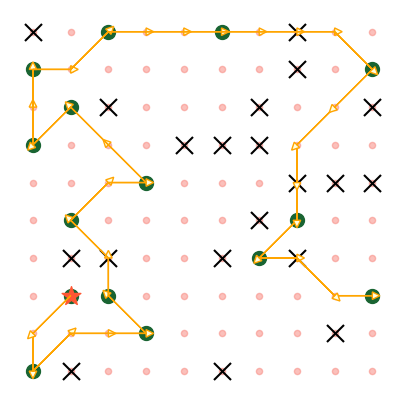

In [36]:
solver = Gurobi;
penalty_factor = 1.0;
x_opt, z_opt, obj_opt = optModelAllowNoGo(grid_data, port_num, port_of_origin_num, no_go_num, penalty_factor, solver);
println("Objective value: $(obj_opt)");
f = visualizeGrid(grid_data, port_num, port_of_origin_num, no_go_num, x_opt.data);

model = A JuMP Model
├ solver: none
├ objective_sense: MIN_SENSE
│ └ objective_function_type: AffExpr
├ num_variables: 10115
├ num_constraints: 30947
│ ├ AffExpr in MOI.EqualTo{Float64}: 9418
│ ├ AffExpr in MOI.LessThan{Float64}: 11414
│ ├ VariableRef in MOI.GreaterThan{Float64}: 100
│ └ VariableRef in MOI.ZeroOne: 10015
└ Names registered in the model
  └ :u, :x, :z
Set parameter Username
Set parameter LicenseID to value 2634157
Academic license - for non-commercial use only - expires 2026-03-09
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: AMD Ryzen 5 8645HS w/ Radeon 760M Graphics, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 20832 rows, 10115 columns and 63203 nonzeros
Model fingerprint: 0xd2f99251
Variable types: 100 continuous, 10015 integer (10015 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00,

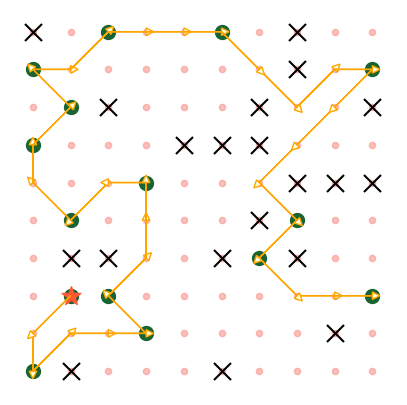

In [37]:
solver = Gurobi;
penalty_factor = 2;
x_opt, z_opt, obj_opt = optModelAllowNoGo(grid_data, port_num, port_of_origin_num, no_go_num, penalty_factor, solver);
println("Objective value: $(obj_opt)");
f = visualizeGrid(grid_data, port_num, port_of_origin_num, no_go_num, x_opt.data);

model = A JuMP Model
├ solver: none
├ objective_sense: MIN_SENSE
│ └ objective_function_type: AffExpr
├ num_variables: 10115
├ num_constraints: 30947
│ ├ AffExpr in MOI.EqualTo{Float64}: 9418
│ ├ AffExpr in MOI.LessThan{Float64}: 11414
│ ├ VariableRef in MOI.GreaterThan{Float64}: 100
│ └ VariableRef in MOI.ZeroOne: 10015
└ Names registered in the model
  └ :u, :x, :z
Set parameter Username
Set parameter LicenseID to value 2634157
Academic license - for non-commercial use only - expires 2026-03-09
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: AMD Ryzen 5 8645HS w/ Radeon 760M Graphics, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 20832 rows, 10115 columns and 63203 nonzeros
Model fingerprint: 0x2f2da362
Variable types: 100 continuous, 10015 integer (10015 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+00,

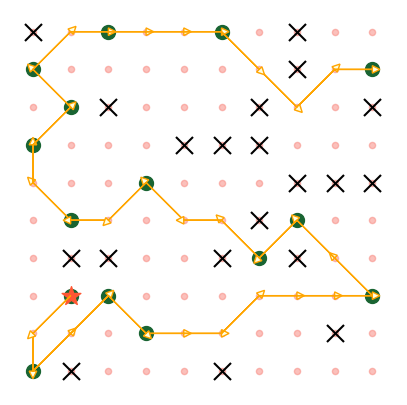

In [38]:
solver = Gurobi;
penalty_factor = 10;
x_opt, z_opt, obj_opt = optModelAllowNoGo(grid_data, port_num, port_of_origin_num, no_go_num, penalty_factor, solver);
println("Objective value: $(obj_opt)");
f = visualizeGrid(grid_data, port_num, port_of_origin_num, no_go_num, x_opt.data);

In [39]:
# For if-then conditions
# utilize previous conditions to ensure good constraints

# why can't lines be eliminated by saying sum of ports with one outgoing 1?

### Max profit

Set parameter Username
Set parameter LicenseID to value 2634157
Academic license - for non-commercial use only - expires 2026-03-09
OPTIMAL
Objective value: 85330.26568792133


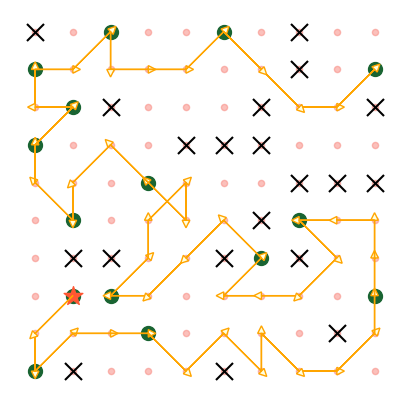

In [41]:
port_profit = randomizePortProfit(grid_data, 1000, 10000);
solver = Gurobi;
x_opt, z_opt, obj_opt = optModelMaxProfit(grid_data, port_num, port_of_origin_num, no_go_num, port_profit, solver);
println("Objective value: $(obj_opt)");
f = visualizeGrid(grid_data, port_num, port_of_origin_num, no_go_num, x_opt.data);

### With boost

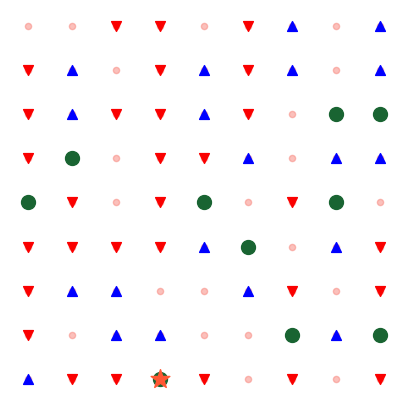

In [26]:
### Grid setup
# grid size (square)
n = 9;
spacing = 1; # always keep 1?

### port information
# number of ports on grid
m = 10;

### no-go zones
k = 30;

# boost zones
b = 20;

grid_data = initializeParam(n, spacing, m, k, b, 0.95);
port_num, port_of_origin_num, no_go_num, boost_num = randomizePortsBoostZones(grid_data)
f = visualizeGridBoost(grid_data, port_num, port_of_origin_num, no_go_num, boost_num, 0);

model = A JuMP Model
├ solver: none
├ objective_sense: MIN_SENSE
│ └ objective_function_type: AffExpr
├ num_variables: 6652
├ num_constraints: 20051
│ ├ AffExpr in MOI.EqualTo{Float64}: 6100
│ ├ AffExpr in MOI.LessThan{Float64}: 7299
│ ├ VariableRef in MOI.GreaterThan{Float64}: 81
│ └ VariableRef in MOI.ZeroOne: 6571
└ Names registered in the model
  └ :u, :x, :z
Set parameter Username
Set parameter LicenseID to value 2634157
Academic license - for non-commercial use only - expires 2026-03-09
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: AMD Ryzen 5 8645HS w/ Radeon 760M Graphics, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 13399 rows, 6652 columns and 40758 nonzeros
Model fingerprint: 0xbe9d08ed
Variable types: 81 continuous, 6571 integer (6571 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [5e-01, 2e+01]


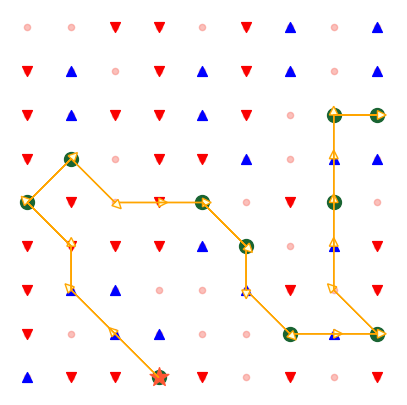

In [27]:
penalty_factor = 2;
boost_factor = 2;
x_opt, z_opt, obj_opt = optModelNoGoBoost(grid_data, port_num, port_of_origin_num, no_go_num, boost_num, penalty_factor, boost_factor, solver)
println("Objective value: $(obj_opt)");
f = visualizeGridBoost(grid_data, port_num, port_of_origin_num, no_go_num, boost_num, x_opt.data);